In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import nltk
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, SimpleRNN, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import  SMOTE
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
pd.set_option('display.max_colwidth', 10000)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Trainning set = {} records and Testing set = {} records.'.format(len(train),len(test)))

Trainning set = 159571 records and Testing set = 153164 records.


In [34]:
print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (159571, 8)
Shape of test data: (153164, 2)


In [35]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [36]:
test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [37]:
null_train = train.isnull().sum()
null_test = test.isnull().sum()
null_train, null_test

(id               0
 comment_text     0
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 dtype: int64,
 id              0
 comment_text    0
 dtype: int64)

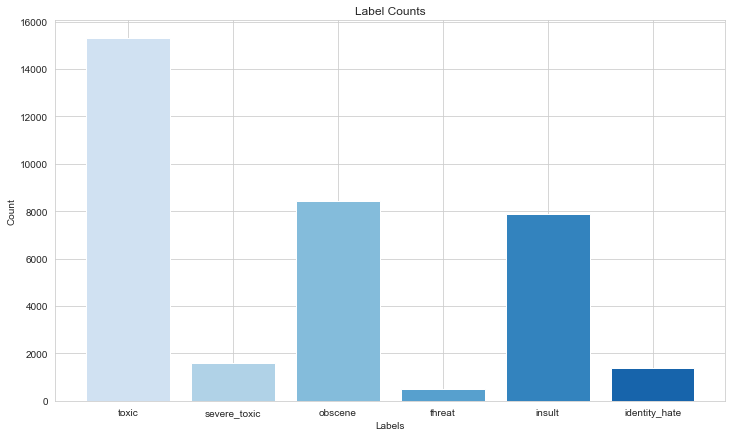

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the sum of each label
labelss = train.iloc[:, 2:].sum()

# Create a colormap based on the counts
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.8, len(labelss)))

# Plot the labelss
plt.figure(figsize=(12, 7))
plt.bar(labelss.index, labelss, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()

# Display the count of labelss
print(labelss)

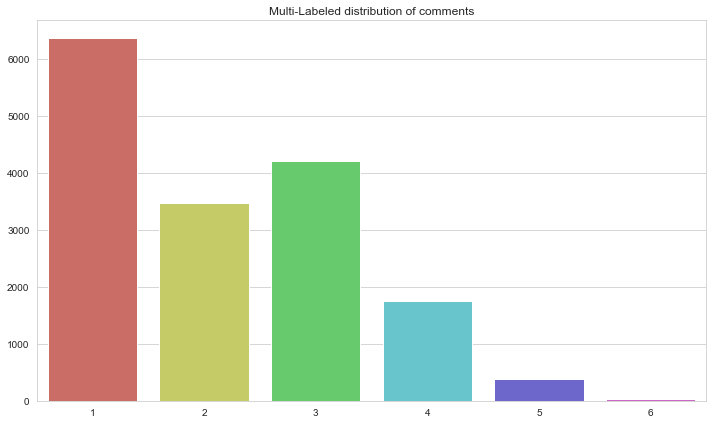

In [39]:
multi_label = train.iloc[:, 2:].sum(axis=1).value_counts()[1:]
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=multi_label.index,
            y=multi_label.values,
            ax=ax,
            palette="hls").set_title("Multi-Labeled distribution of comments")

plt.show()

In [40]:
# labels = train.iloc[:,2:8]
# row_sum = labels.sum(axis = 1)
# # mark comments without any labels as "non-toxic"
# train['Non-toxic'] = (row_sum == 0)
# print('Total comments is {}.'.format(len(train)))
# print('Non toxic comments are {}, which is {} of total comments.'.format(train['Non-toxic'].sum(),train['Non-toxic'].sum()/len(train)))

Total comments is 159571.
Non toxic comments are 143346, which is 0.8983211235124177 of total comments.


In [42]:
labels = train.iloc[:, 2:8]
row_sum = labels.sum(axis=1)

train['Non-toxic'] = (row_sum == 0)

total_comments = len(train)
non_toxic_comments = train['Non-toxic'].sum()
percent_non_toxic = (non_toxic_comments / total_comments) * 100

print('Total comments: {}.'.format(total_comments))
print('Non-toxic comments: {}, which is {:.2f}% of total comments.'.format(non_toxic_comments, percent_non_toxic))

Total comments: 159571.
Non-toxic comments: 143346, which is 89.83% of total comments.


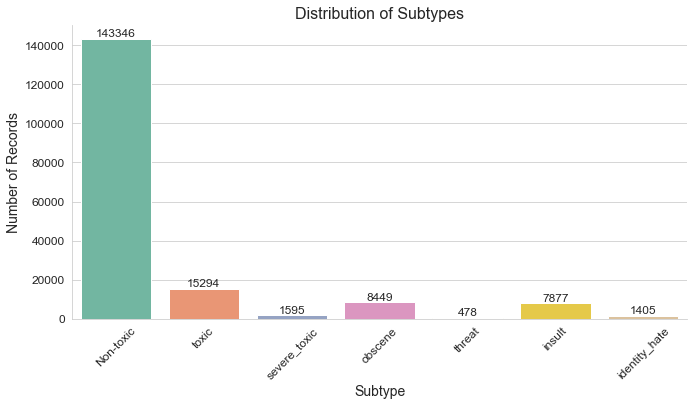

In [43]:
col_sum = pd.Series(labels.sum(axis=0))
Non_toxic = pd.Series(train['Non-toxic'].sum(), index=['Non-toxic'])
col_sum = pd.concat([Non_toxic, col_sum])

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Set the style of the plot

ax = sns.barplot(col_sum.index, col_sum.values, palette="Set2")  # Customize the color palette

# Add labels to the bars
for rect, label in zip(ax.patches, col_sum.values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,
            ha='center', va='bottom', fontsize=12)

# Set labels and title
plt.xlabel('Subtype', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.title('Distribution of Subtypes', fontsize=16)

# Customize tick labels and font size
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust the layout and padding
plt.tight_layout(pad=2)

# Display the plot
plt.show()

In [44]:
diff_comm = ['Non-toxic', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in diff_comm:
    record_number = random.randint(1, train[t].sum())
    print('{}th record is "{}":'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')

32726th record is "Non-toxic":
I dont understand, what do you mean?

If you think the nummbers are wrong then I would be very happy to hear you oppinion D
I dont mean that in any sarcastic way or nothing like that because I would be very happy to talk nummbers with someone who actually knows them and it seems that you do D

And am I your pal D

( )

5168th record is "toxic":
editheadz 
Will you keep your stupid mouth shut for once? You have NO IDEA, not even a CLUE what you are talkign about, idiot! - Julius

722th record is "severe_toxic":
fuk u retard i hate u i will kill u bettr watch ur bak cuz im teamin up wit my mothafuka boothy and we gonna rise the south on yo ass bitch

7260th record is "obscene":
"

 DAMN FKER ITS ME 24...173. ONCE AGAIN, MY IP ADDRESS CHANGES AFTER AN ADMISTOR BANNS IT!!!!!!!! GET IT YET YOU ""FEMALE DOG"" "

1th record is "threat":
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndom

In [45]:
train['comment_text'][0:5]

0                                                                                                                                                                                                                                                                                                                                                                             Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1                                                                                                                                                                                                                                                                                                                                                                               

In [46]:
# def clean_docu(text_record):
#     # split tokens by white space
#     tokens = text_record.split()
#     # remove punctuation from each string
#     table = str.maketrans({key: None for key in string.punctuation})
#     tokens = [token.translate(table) for token in tokens]
#     # remove tokens that are not alphabetic
#     tokens = [token for token in tokens if token.isalpha()]
#     # convert letters to lower case
#     tokens = [token.lower() for token in tokens]
#     # remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tokens = [token for token in tokens if token not in stop_words]
#     # remove short words (one letter)
#     tokens = [token for token in tokens if len(token) > 1]
#     # lemmatization
#     lem = WordNetLemmatizer()
#     tokens = [lem.lemmatize(token,"v") for token in tokens]
#     sentence = ' '.join(tokens)
#     return sentence

In [48]:
def clean_data(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token, "v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [49]:
train_cleaned = [clean_data(comment) for comment in train.comment_text.copy()]
test_cleaned = [clean_data(comment) for comment in test.comment_text.copy()]

In [50]:
train_cleaned[0:5]

['Explanation Why edit make username Hardcore Metallica Fan revert They werent vandalisms closure GAs I vote New York Dolls FAC And please dont remove template talk page since Im retire',
 'Daww He match background colour Im seemingly stick Thanks talk January UTC',
 'Hey man Im really try edit war Its guy constantly remove relevant information talk edit instead talk page He seem care format actual info',
 'More I cant make real suggestions improvement I wonder section statistics later subsection type accidents I think reference may need tidy exact format ie date format etc I later noone else first preferences format style reference want please let know There appear backlog article review I guess may delay reviewer turn Its list relevant form eg WikipediaGoodarticlenominationsTransport',
 'You sir hero Any chance remember page thats']

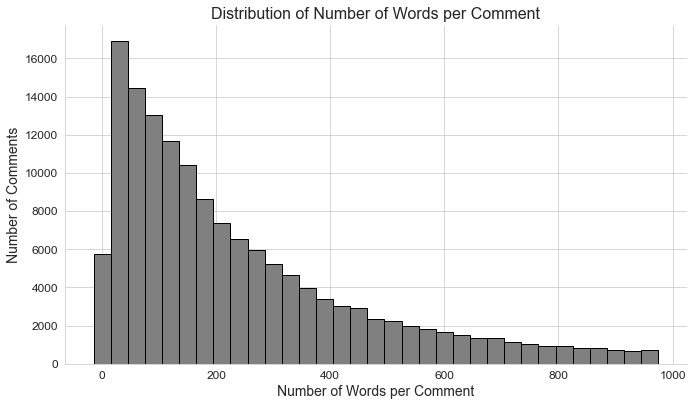

No. with maximum count: 30
Count: 16908


In [51]:
num_words = [len(comment) for comment in train.comment_text]

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Set the style of the plot

# Calculate the count of each bin
hist, bins = np.histogram(num_words, bins=np.arange(0, 1000, 30))

# Set the desired color
bar_color = 'gray'

# Plot the bar plot
plt.bar(bins[:-1], hist, width=30, color=bar_color, edgecolor='black')

# Set labels and title
plt.xlabel('Number of Words per Comment', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.title('Distribution of Number of Words per Comment', fontsize=16)

# Customize tick labels and font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust the layout and padding
plt.tight_layout(pad=2)

# Display the plot
plt.show()

# Find the number with the maximum count
max_count = np.max(hist)
max_num_words = bins[np.argmax(hist)]

print("No. with maximum count:", max_num_words)
print("Count:", max_count)

In [52]:
max_features = 25000
tokens = Tokenizer(num_words = max_features)
tokens.fit_on_texts(train_cleaned)
train_encoded = tokens.texts_to_sequences(train_cleaned)
test_encoded = tokens.texts_to_sequences(test_cleaned)
# vocabulary size
print('Vocab_size = {}.'.format(len(tokens.word_index)))
# examples
#print(train_encoded[0])

Vocab_size = 209420.


In [53]:
max_len = 250
X_train = pad_sequences(train_encoded, maxlen = max_len, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = max_len, padding = 'post')

attribute_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[attribute_names].values

In [54]:
print('X_train shape is {}'.format(X_train.shape))
print('y_train shape is {}'.format(y_train.shape))

X_train shape is (159571, 250)
y_train shape is (159571, 6)


In [55]:
'''Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. 
Multilabel and multioutput targets are not supported.''' 
word_vectors = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 6),
    max_features=25000
)

word_vectors.fit(train_cleaned)
train_features = word_vectors.transform(train_cleaned)
test_features = word_vectors.transform(test_cleaned)

In [56]:
cross_scores = []
for attri_name in attribute_names:
    train_target = train[attri_name]
    classifier = LogisticRegression(C=0.2, solver='sag')
    cv_scores = cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cross_scores.append(cv_score)
    print('Cross_Val score for "{}" is {}'.format(attri_name, cv_score))
    classifier.fit(train_features, train_target)
    
print('Total Cross_Val score is {}'.format(np.mean(cross_scores)))

Cross_Val score for "toxic" is 0.9616591659186152
Cross_Val score for "severe_toxic" is 0.9819385108633192
Cross_Val score for "obscene" is 0.9801007781993682
Cross_Val score for "threat" is 0.976035761533136
Cross_Val score for "insult" is 0.9707877363385705
Cross_Val score for "identity_hate" is 0.9686250465693341
Total Cross_Val score is 0.9731911665703906


In [57]:
class roc_auc(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc, 4)), str(round(roc_val, 4))), end=100 * ' ' + '\n')

In [58]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath):
    # callbacks
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    
    roc = roc_auc(training_data=(X_train, y_train), validation_data=(X_val, y_val))
    
    # fit the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc, checkpointer])
    
    # load the model with the best validation loss
    model.load_weights(filepath)
    
    return model, history

In [59]:
lstm = Sequential()
lstm.add(Embedding(max_features, 100, input_length=max_len))
lstm.add(LSTM(64))
lstm.add(Dropout(0.25))
lstm.add(Dense(6, activation="sigmoid"))

lstm.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          2500000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 2,542,630
Trainable params: 2,542,630
Non-trainable params: 0
_________________________________________________________________


2023-06-07 21:17:15.305430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 21:17:15.309459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 21:17:15.312578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

lstm_trained, history_lstm = train_model(lstm,
                                         X_train, y_train,
                                         X_val, y_val,
                                         batch_size=512,
                                         epochs=3,
                                         filepath='saved_models/weights.best.from_scatch_lstm.hdf5')

Epoch 1/3


2023-06-07 21:17:20.653510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 21:17:20.656119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 21:17:20.657450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.1679

2023-06-07 21:23:23.301868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 21:23:23.304169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 21:23:23.305979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

   1/4488 [..............................] - ETA: 37:36

2023-06-07 21:23:35.967368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 21:23:35.968583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 21:23:35.970656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

499/499 [==============================] - 16s 33ms/step
roc-auc: 0.5075 - roc-auc_val: 0.5191                                                                                                    

Epoch 1: val_loss improved from inf to 0.35678, saving model to saved_models/weights.best.from_scatch_lstm.hdf5
281/281 [==============================] - 540s 2s/step - loss: 0.3991 - accuracy: 0.1679 - val_loss: 0.3568 - val_accuracy: 0.0018
Epoch 2/3
499/499 [==============================] - 16s 33ms/step
roc-auc: 0.5054 - roc-auc_val: 0.5155                                                                                                    

Epoch 2: val_loss improved from 0.35678 to 0.35288, saving model to saved_models/weights.best.from_scatch_lstm.hdf5
281/281 [==============================] - 529s 2s/step - loss: 0.3966 - accuracy: 0.2089 - val_loss: 0.3529 - val_accuracy: 0.0033
Epoch 3/3
 972/4488 [=====>........................] - ETA: 21:04

In [63]:
rnn = Sequential()
rnn.add(Embedding(max_features, 100, input_length=max_len))
rnn.add(SimpleRNN(100))
rnn.add(Dense(6, activation='sigmoid'))
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          2500000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 2,520,706
Trainable params: 2,520,706
Non-trainable params: 0
_________________________________________________________________


In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)
rnn_trained, history_rnn = train_model(rnn,
                                X_train,y_train,
                                X_val,y_val,
                                batch_size=512, 
                                epochs=5,
                                filepath='saved_models/weights.best.from_scratch_rnn.hdf5')

Epoch 1/5
449/449 [==============================] - 9s 20ms/step
roc-auc: 0.5061 - roc-auc_val: 0.5073                                                                                                    

Epoch 1: val_loss improved from inf to 0.14073, saving model to saved_models/weights.best.from_scratch_rnn.hdf5
253/253 [==============================] - 281s 1s/step - loss: 0.1492 - accuracy: 0.9895 - val_loss: 0.1407 - val_accuracy: 0.9941
Epoch 2/5
449/449 [==============================] - 9s 21ms/step
roc-auc: 0.723 - roc-auc_val: 0.7094                                                                                                    

Epoch 2: val_loss improved from 0.14073 to 0.13363, saving model to saved_models/weights.best.from_scratch_rnn.hdf5
253/253 [==============================] - 290s 1s/step - loss: 0.3462 - accuracy: 0.7009 - val_loss: 0.1336 - val_accuracy: 0.9817
Epoch 3/5
449/449 [==============================] - 9s 20ms/step
roc-auc: 0.8484 - roc-auc_val: 0.

In [65]:
with open('rnn_model.pkl', 'wb') as f:
    pickle.dump(rnn, f)

In [66]:
with open('rnn_model.pkl', 'rb') as f:
    rnn_model = pickle.load(f)


In [67]:
y_pred_val = rnn_model.predict(X_val)

# Calculate AUC using y_pred_val and y_val
auc = roc_auc_score(y_val, y_pred_val)
print("AUC: %.2f%%" % (auc * 100))

449/449 [==============================] - 10s 22ms/step
AUC: 80.62%


In [68]:

# Build CNN model
cnn = Sequential()
cnn.add(Embedding(max_features, 200, input_length=max_len))  # Increase embedding dimension to 200
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Increase number of filters to 32
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.5))
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  # Increase number of filters to 64
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(500, activation="relu"))  # Increase number of units in the dense layer to 800
cnn.add(Dropout(0.5))
cnn.add(Dense(6, activation="sigmoid"))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 200)          5000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 124, 32)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 124, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 61, 64)           0         
 1D)                                                  

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

cnn_trained, history_cnn = train_model(cnn,
                                       X_train,y_train,
                                       X_val,y_val,
                                       batch_size=512, 
                                       epochs=3,
                                       filepath='saved_models/weights.best.from_scatch_cnn.hdf5')

Epoch 1/3
404/404 [==============================] - 6s 16ms/step
roc-auc: 0.9655 - roc-auc_val: 0.9433                                                                                                    

Epoch 1: val_loss improved from inf to 0.07766, saving model to saved_models/weights.best.from_scatch_cnn.hdf5
228/228 [==============================] - 194s 846ms/step - loss: 0.1142 - accuracy: 0.7955 - val_loss: 0.0777 - val_accuracy: 0.9939
Epoch 2/3
404/404 [==============================] - 6s 15ms/step
roc-auc: 0.9786 - roc-auc_val: 0.9578                                                                                                    

Epoch 2: val_loss improved from 0.07766 to 0.06480, saving model to saved_models/weights.best.from_scatch_cnn.hdf5
228/228 [==============================] - 203s 892ms/step - loss: 0.0628 - accuracy: 0.9553 - val_loss: 0.0648 - val_accuracy: 0.9939
Epoch 3/3
404/404 [==============================] - 6s 15ms/step
roc-auc: 0.9822 - roc-auc_va

In [70]:
# gru = Sequential()
# gru.add(Embedding(len(word_index) + 1,
#                      300,
#                      weights=[embedding_matrix],
#                      input_length=max_len,
#                      trainable=False))
# gru.add(SpatialDropout1D(0.3))
# gru.add(GRU(300))
# gru.add(Dense(1, activation='sigmoid'))

# gru.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# gru.summary()

In [71]:
gru = Sequential()
gru.add(Embedding(max_features, 200, input_length=max_len))
gru.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))  # Add GRU layer with 32 units
gru.add(Dense(6, activation='sigmoid'))

gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 200)          5000000   
                                                                 
 gru (GRU)                   (None, 32)                22464     
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                                                 
Total params: 5,022,662
Trainable params: 5,022,662
Non-trainable params: 0
_________________________________________________________________


In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

gru_trained, history_gru = train_model(gru,
                                       X_train, y_train,
                                       X_val, y_val,
                                       batch_size=512,
                                       epochs=3,
                                       filepath='saved_models/weights.best.from_scatch_gru.hdf5')

Epoch 1/3
364/364 [==============================] - 13s 36ms/step
roc-auc: 0.503 - roc-auc_val: 0.5022                                                                                                    

Epoch 1: val_loss improved from inf to 0.13589, saving model to saved_models/weights.best.from_scatch_gru.hdf5
205/205 [==============================] - 484s 2s/step - loss: 0.2042 - accuracy: 0.6807 - val_loss: 0.1359 - val_accuracy: 0.9942
Epoch 2/3
364/364 [==============================] - 14s 39ms/step
roc-auc: 0.5203 - roc-auc_val: 0.5191                                                                                                    

Epoch 2: val_loss improved from 0.13589 to 0.13523, saving model to saved_models/weights.best.from_scatch_gru.hdf5
205/205 [==============================] - 1700s 8s/step - loss: 0.1409 - accuracy: 0.9936 - val_loss: 0.1352 - val_accuracy: 0.9941
Epoch 3/3
364/364 [==============================] - 16s 43ms/step
roc-auc: 0.4939 - roc-auc_val: 

In [23]:
# model_rnn = Sequential()
# model_rnn.add(Embedding(max_features, 100, input_length=maxlen))
# model_rnn.add(Bidirectional(LSTM(128, return_sequences=True)))
# model_rnn.add(GlobalMaxPool1D())
# model_rnn.add(Dropout(0.25))
# model_rnn.add(Dense(60, activation="relu"))
# model_rnn.add(Dropout(0.25))
# model_rnn.add(Dense(6, activation="sigmoid"))

# # summary
# model_rnn.summary()

2023-06-06 04:44:10.405006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 04:44:10.407033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 04:44:10.408432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 256)         234496    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                15420     
                                                                 
 dropout_4 (Dropout)         (None, 60)               

2023-06-06 04:44:10.643609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 04:44:10.646877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 04:44:10.649982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
# model_rnn_trained, history_rnn = train_model(model_rnn,
#                                 X_train,y_train,
#                                 X_val,y_val,
#                                 batch_size=512, 
#                                 epochs=3,)

Epoch 1/5


2023-06-06 04:44:28.281006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 04:44:28.283848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 04:44:28.286050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.7026

2023-06-06 05:11:42.878602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 05:11:42.881897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 05:11:42.884227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

499/499 [==============================] - 521s 1s/step
roc-auc: 0.9595 - roc-auc_val: 0.955                                                                                                    

Epoch 1: val_loss improved from inf to 0.06064, saving model to saved_models/weights.best.from_scratch_rnn.hdf5
281/281 [==============================] - 5255s 19s/step - loss: 0.1365 - accuracy: 0.7026 - val_loss: 0.0606 - val_accuracy: 0.9946
Epoch 2/5
499/499 [==============================] - 612s 1s/step
roc-auc: 0.9788 - roc-auc_val: 0.9744                                                                                                    

Epoch 2: val_loss improved from 0.06064 to 0.04923, saving model to saved_models/weights.best.from_scratch_rnn.hdf5
281/281 [==============================] - 15136s 54s/step - loss: 0.0557 - accuracy: 0.9507 - val_loss: 0.0492 - val_accuracy: 0.9946
Epoch 3/5
499/499 [==============================] - 90s 180ms/step
roc-auc: 0.9817 - roc-auc_val: 0.974